In [ ]:
import pickle
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer

# RNN

## about the dataset:

This study will utilize the MIMIC III electronic health record (EHR) dataset, which is comprised of over 58,000 hospital admissions for 38,645 adults and 7,875 neonates. This dataset is a collection of de-identified intensive care unit stays at the Beth Israel Deaconess Medical Center from June 2001- October 2012.

In this tutorial, we use subset of MIMIC III data, that includes the EHR of 7537 patients.

Noticed that the data is pre-processed based on the original EHR data. We have an extra notebook to introduce the whole progress about how to process the EHR data. But for now, let's focus on the RNN section at first.

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
if not os.path.exists('/content/Jan19.seqs'):
    link = '1SMjZxpZKlOzisbAXF-Na6_dWkx9j8UL7'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link}) 
    downloaded.GetContentFile('Jan19.seqs')

seqs = np.array(pickle.load(open('/content/Jan19.seqs','rb')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# the number of patients
print(len(seqs))

7537


Each EHR might includes multiple records about the events in each visiting for each patients. There are 4895 kinds of events in total. The records are ordered by the visting time.

In [ ]:
# the EHR of first two patient.
print(seqs[:3])

[list([[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 2, 5, 11, 4, 12, 13, 14]])
 list([[15, 16, 17, 18, 19, 20, 0, 21], [22, 23, 24, 0, 25, 16, 26, 27]])
 list([[0, 1, 28, 5, 29, 30, 6, 31, 32], [33, 34, 35, 36, 37, 28, 0, 12, 5, 6, 30, 31], [38, 35, 39, 40, 41, 42, 43, 28, 5, 6, 44, 31]])]


There are two key problems about the loaded dataset.

1. the number of records are different for each patient. Some patients visit docotor frequenly while other might only visit once.
2. the number of recorded events are different in each record.


It is improtant for us to make sure the data to has same size. Because the network can only accept such data.

Let's use the data below as an example

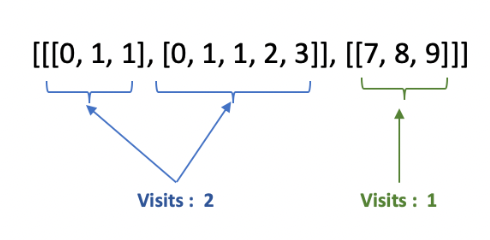

For the first problem, we can apply padding to the shorter data. We first arrange each mini-batch by the patient visits in descending order. In this the patient 1 has the longest visit history with a total of two visits, while patient 2's visits will be padded to the max length of 2, since it's the longest sequence. As shown here:


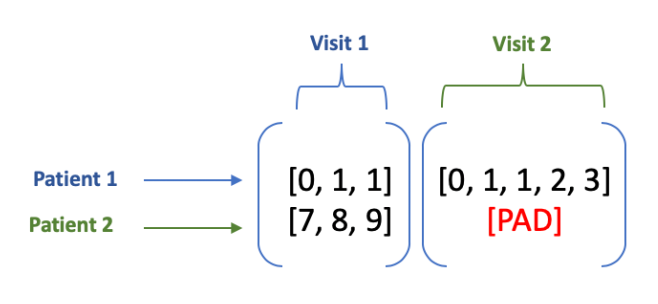

For the second problem, we can transfer each record into binary format. Let's assume there are 10 kinds of event in total. In the binary format, each record will be 10 dimension length. And the value in the index of corresponding event number will be the 1. For example, if the record includes event 7, then the value of index 7 should be 1 in its binary format.

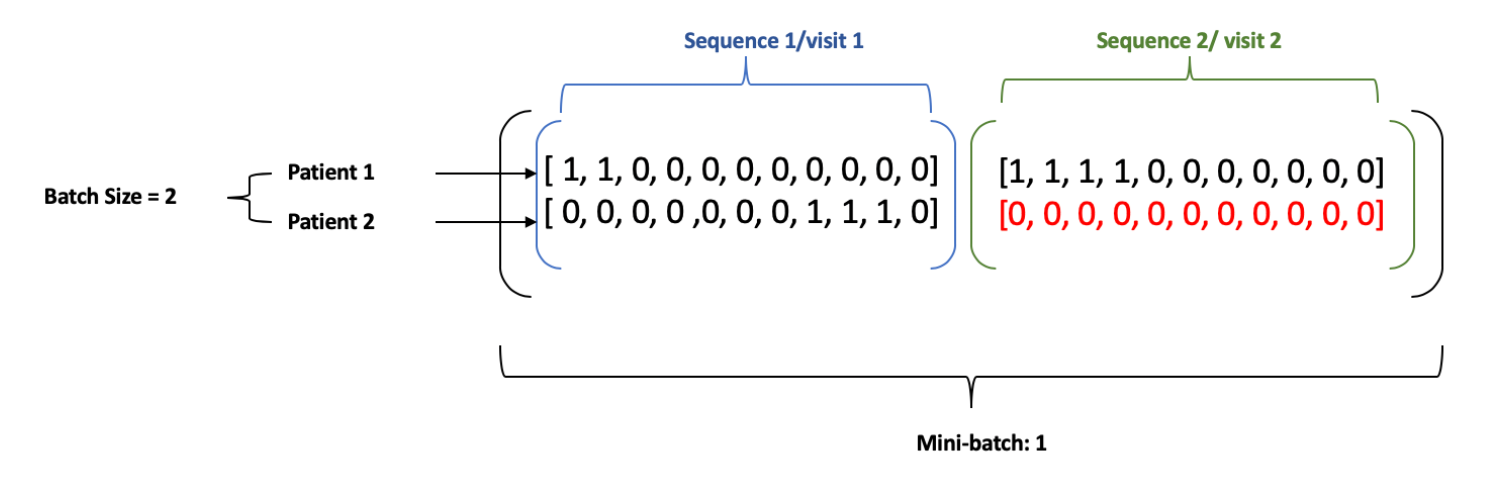

labels:

As we mentioed before, given a data of one specific timestamp, the RNN will predict the data happen in the next timestamp. Thus given a sequences of data as input, the RNN will output a sequence of data (which length of the sequence is same as the input).

For example: 

Assuming the input timestamp: 1, 2, 3, ...., t-1, t

The timestamp of the predicted output will be: 2, 3, 4, ...., t, t+1

To trian the model, we can select `X[:-1]` as the input (i.e., 1, 2,3,...,t-2,t-1).

And X[1:] as the ground truth labels (i.)

In [ ]:
def padding(seqs, labels, inputDimSize, numClass):
    lengths = np.array([len(seq) for seq in seqs]) - 1
    maxlen = np.max(lengths)
    num_samples = len(seqs)

    shapee = np.arange(0,numClass+1)
    mlb = MultiLabelBinarizer(classes=shapee)

    max_length = 0

    # calculate the max length of the sequences.
    for idx, seq in enumerate(seqs):
      max_length = max(max_length, len(seq))

    max_length = 10
    
    x = []
    y = []
    length_list = []
    for idx, (seq, label) in enumerate(zip(seqs, labels)):
      if (len(seq) == 1):
        continue
      length_list.append(len(seq)-1)
      if (len(seq)>= 11):
        seq = seq[:11]
        label = label[:11]
      seq = seq[:-1]
      label = label[1:]
      
      for i in range(max_length):
        if (i>=lengths[idx]):
          seq.append([-1])
          label.append([-1])

      x.append(torch.FloatTensor(mlb.fit_transform(seq)))
      y.append(torch.FloatTensor(mlb.fit_transform(label)))

    
    #packed = pack_sequence(x)

    #return torch.cat(x, dim=0), torch.cat(y, dim=0), lengths
    return x, y, lengths

In [ ]:
x, y, lengths= padding(seqs.copy(), seqs.copy(), 4894, 4894)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:876: UserWarning: unknown class(es) [-1] will be ignored
  "unknown class(es) {0} will be ignored".format(sorted(unknown, key=str))


In [ ]:
x = torch.stack(x)
y = torch.stack(y)

In [ ]:
print(y.shape)

torch.Size([7537, 10, 4895])


split the data into training and testing set.

In [ ]:
train_x = x[:int(0.85*len(x))]
train_y = y[:int(0.85*len(x))]
train_lengths = lengths[:int(0.85*len(lengths))]

test_x = x[int(0.85*len(x)):]
test_y = y[int(0.85*len(y)):]
test_lengths = lengths[int(0.85*len(lengths)):]

In [ ]:
print(len(train_x))
# print(test_y.shape)
print(len(test_lengths))
print(len(train_lengths))

6406
1131
6406


In [ ]:
class Dataset():
    def __init__(self, x, y, lengths):
        self.x, self.y, self.lengths = x, y, lengths
        print(len(self.x), len(self.lengths))
    def __len__(self): return len(self.x)
    def __getitem__(self, i ): return self.x[i], self.y[i], self.lengths[i]

In [ ]:
train_ds = Dataset(train_x, train_y, train_lengths)
test_ds = Dataset(test_x, test_y, test_lengths)

6406 6406
1131 1131


In [ ]:
from torch.utils.data import DataLoader 
train_loader = DataLoader(train_ds,shuffle=True,batch_size=10)
test_loader = DataLoader(test_ds,shuffle=False,batch_size=10)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct  3 06:13:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = nn.RNN(4895, 4895, 2, batch_first=True)
model = model.cuda()

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
epochs = 10
m = nn.Sigmoid()

In [ ]:
for i in range(epochs):
    for j,data in enumerate(train_loader):
        x, y, lengths = data
        x = x.cuda()
        y = y.cuda()
        lengths = lengths.long()
        #print(x.shape)
        if j % 20 == 0:
            print('  %d / %d'%(j * x.shape[0], len(train_x)))
        #packed_data = pack_padded_sequence(x, lengths, batch_first=True,enforce_sorted=False)

        #output, _ = model(packed_data)
        output, _ = model(x)

        output = m(output)
        #unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(output)
        #print(unpacked.shape)


        #print(unpacked_len[:10])
        #loss = criterion(unpacked, y)
        loss = criterion(output, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        optimizer.zero_grad()
    
    print(i,"th iteration : ",loss)

  0 / 6406
  200 / 6406
  400 / 6406
  600 / 6406
  800 / 6406
  1000 / 6406
  1200 / 6406
  1400 / 6406
  1600 / 6406
  1800 / 6406
  2000 / 6406
  2200 / 6406
  2400 / 6406
  2600 / 6406
  2800 / 6406
  3000 / 6406
  3200 / 6406
  3400 / 6406
  3600 / 6406
  3800 / 6406
  4000 / 6406
  4200 / 6406
  4400 / 6406
  4600 / 6406
  4800 / 6406
  5000 / 6406
  5200 / 6406
  5400 / 6406
  5600 / 6406
  5800 / 6406
  6000 / 6406
  6200 / 6406
  3840 / 6406
0 th iteration :  tensor(0.3354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
  0 / 6406
  200 / 6406
  400 / 6406
  600 / 6406
  800 / 6406
  1000 / 6406
  1200 / 6406
  1400 / 6406
  1600 / 6406
  1800 / 6406
  2000 / 6406
  2200 / 6406
  2400 / 6406
  2600 / 6406
  2800 / 6406
  3000 / 6406
  3200 / 6406
  3400 / 6406
  3600 / 6406
  3800 / 6406
  4000 / 6406
  4200 / 6406
  4400 / 6406
  4600 / 6406
  4800 / 6406
  5000 / 6406
  5200 / 6406
  5400 / 6406
  5600 / 6406
  5800 / 6406
  6000 / 6406
  6200 / 6406
  3840 / 6406
1

In [ ]:
!pip install hcrystalball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 788 kB 32.1 MB/s 
     |████████████████████████████████| 208 kB 76.6 MB/s 
     |████████████████████████████████| 70 kB 9.8 MB/s 


# Autoregressive model

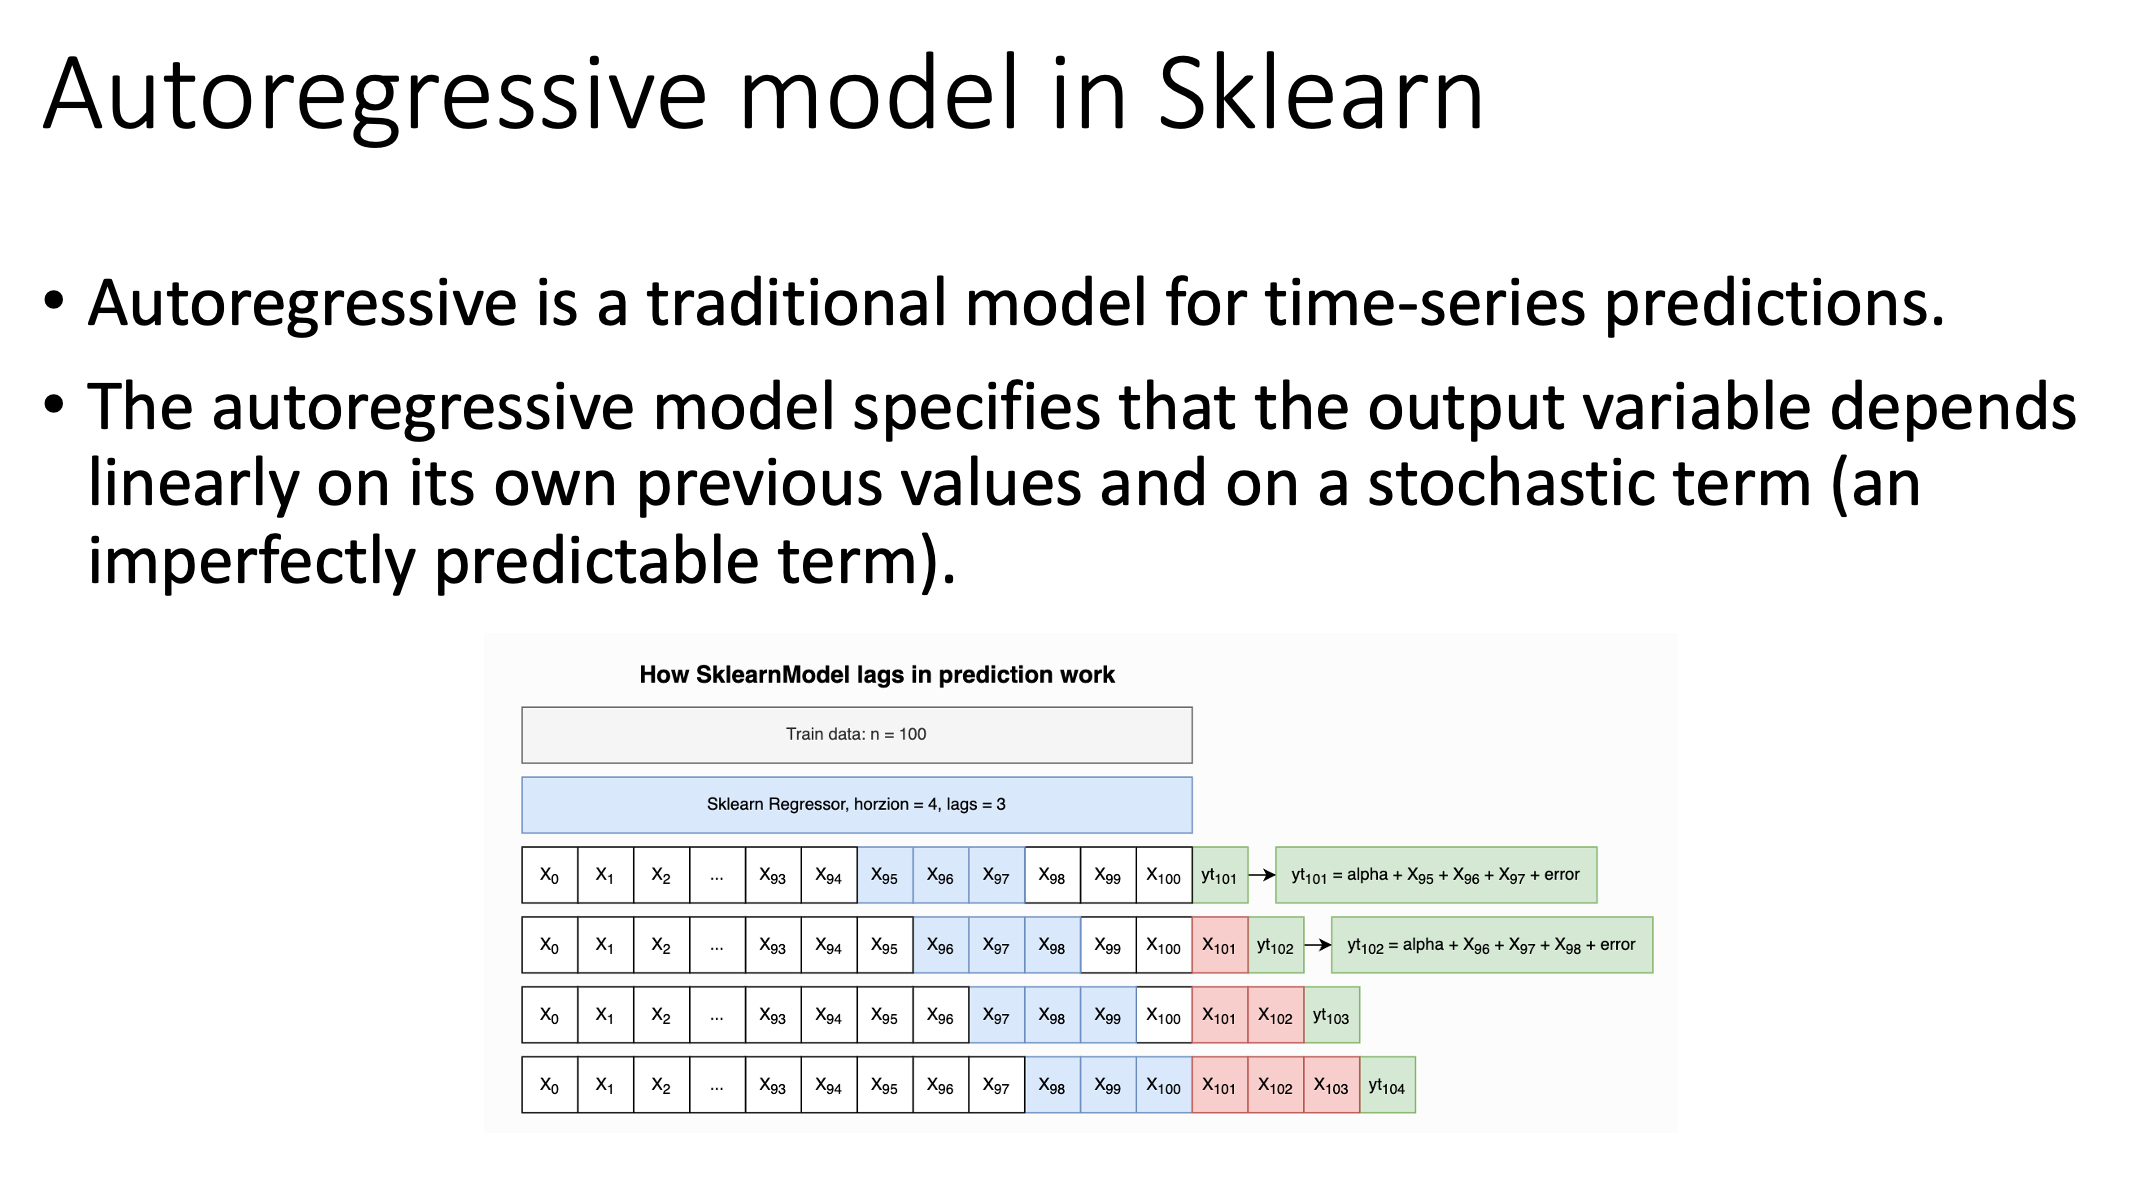

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=365*2,
                    n_assortments=1,
                    n_states=1,
                    n_stores=1)
X, y = pd.DataFrame(index=df.index), df['Sales']

In [ ]:
from hcrystalball.wrappers import get_sklearn_wrapper


In [ ]:
from sklearn.ensemble import RandomForestRegressor


In [ ]:
print(X)

Empty DataFrame
Columns: []
Index: [2013-08-01 00:00:00, 2013-08-02 00:00:00, 2013-08-03 00:00:00, 2013-08-04 00:00:00, 2013-08-05 00:00:00, 2013-08-06 00:00:00, 2013-08-07 00:00:00, 2013-08-08 00:00:00, 2013-08-09 00:00:00, 2013-08-10 00:00:00, 2013-08-11 00:00:00, 2013-08-12 00:00:00, 2013-08-13 00:00:00, 2013-08-14 00:00:00, 2013-08-15 00:00:00, 2013-08-16 00:00:00, 2013-08-17 00:00:00, 2013-08-18 00:00:00, 2013-08-19 00:00:00, 2013-08-20 00:00:00, 2013-08-21 00:00:00, 2013-08-22 00:00:00, 2013-08-23 00:00:00, 2013-08-24 00:00:00, 2013-08-25 00:00:00, 2013-08-26 00:00:00, 2013-08-27 00:00:00, 2013-08-28 00:00:00, 2013-08-29 00:00:00, 2013-08-30 00:00:00, 2013-08-31 00:00:00, 2013-09-01 00:00:00, 2013-09-02 00:00:00, 2013-09-03 00:00:00, 2013-09-04 00:00:00, 2013-09-05 00:00:00, 2013-09-06 00:00:00, 2013-09-07 00:00:00, 2013-09-08 00:00:00, 2013-09-09 00:00:00, 2013-09-10 00:00:00, 2013-09-11 00:00:00, 2013-09-12 00:00:00, 2013-09-13 00:00:00, 2013-09-14 00:00:00, 2013-09-15 00:00:00

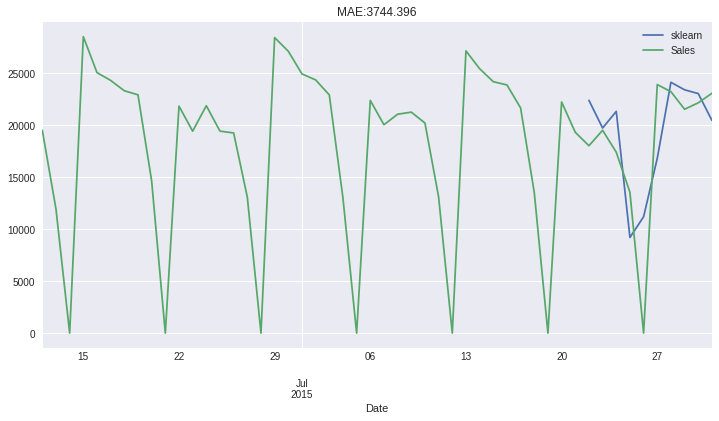

In [ ]:
model = get_sklearn_wrapper(RandomForestRegressor, n_estimators=100, clip_predictions_lower=0., random_state=42)
preds = (model.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)    
)
preds.plot(title=f"MAE:{(preds['Sales']-preds['sklearn']).abs().mean().round(3)}");